# SFINCS Model setup

We want to combine data from the SRTM of resolution 30 m with data by Lin et al. for the river widths.

In [16]:
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

import hydromt
import hydromt_sfincs
from hydromt.config import configread
from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel, utils

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

logger = setuplog("prepare data catalog", log_level=10)

2024-03-12 14:23:03,018 - prepare data catalog - log - INFO - HydroMT version: 0.9.4


**Steps followed in this notebook to build your SFINCS model:**
<ol> 
<li> Open SfincsModel class, set data library and output folder </li>
<li> Specify characteristics of the wanted grid </li>
<li> Load in wanted elevation datasets </li>
<li> Make mask of active and inactive cells </li>
<li> Update mask with water level and outflow boundary cells</li>
<li> Add spatially varying roughness data</li>
<li> Make subgrid derived tables</li>
<li> Add spatially varying infiltration data</li>
<li> Add water level time-series as forcing</li>
<li> Add an upstream discharge time-series as forcing</li>
<li> Add spatially varying rainfall data</li>
<li> Add weirfile</li>
<li> Add observation points</li>
<li> Add observation lines</li>
<li> Show model</li>
<li> Save all files</li>
</ol> 

### 1. Initialize SfincsModel class, set data library and output folder:

In [2]:
model_root = Path(r"model")
data_libs = [
    Path(r"data/1_static/data_static_garissa.yml"),
    #Path(r"data/2_forcing/data_forcing.yml"),
]
base_root = Path(r"model/base")

data_catalog = hydromt.DataCatalog(data_libs=data_libs, logger=logger)

2024-03-12 14:14:37,088 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_garissa.yml


### 2. Specify characteristics of the wanted grid and generate grid:

In [3]:
# bbox = [36.6209722222222140, -3.1540277777777708,
#          41.5604166666666472, 0.4798611111111084]
# region = {"bbox": bbox}

model = SfincsModel(root=base_root, data_libs=data_libs, mode="w+", logger=logger)

2024-03-12 14:14:37,178 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_garissa.yml


2024-03-12 14:14:37,194 - prepare data catalog - log - DEBUG - Appending log messages to file c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\base\hydromt.log.
2024-03-12 14:14:37,195 - prepare data catalog - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).


{'mmax': 120, 'nmax': 400, 'dx': 100.0, 'dy': 100.0, 'x0': 572326.348205529, 'y0': 9933677.651715364, 'rotation': 28, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 32737}


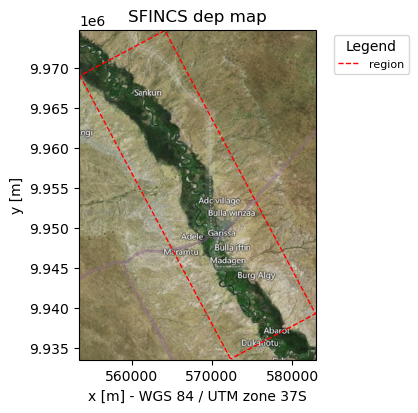

In [4]:
# model.setup_grid(
#     x0=39.65, #672889606923,
#     y0=-0.60, #45884215259317,
#     dx=0.001,
#     dy=0.0005,
#     nmax=600,
#     mmax=100,
#     rotation=28,
#     epsg=4326,
# )

# Now set up the grid with the transformed coordinates
model.setup_grid(
    x0=572326.348205529,
    y0=9933677.651715364,
    dx=100.0,  
    dy=100.0,
    nmax=400,
    mmax=120,
    rotation=28,
    epsg=32737, 
)

print(model.config)

_ = model.plot_basemap(plot_region=True, bmap="sat")

### 3. Load in wanted elevation datasets:

2024-03-12 14:14:42,946 - prepare data catalog - rasterdataset - INFO - Reading merit_hydro raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\s05e035\{variable}.tif
2024-03-12 14:14:43,156 - prepare data catalog - rasterdataset - INFO - Reading srtm30 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\srtm30\STRM30DEM_tana.tif
2024-03-12 14:14:43,191 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.481, -0.600, 39.745, -0.230] (epsg:4326))
2024-03-12 14:14:43,513 - prepare data catalog - merge - DEBUG - Reprojection method of first dataset is: bilinear
Plotting


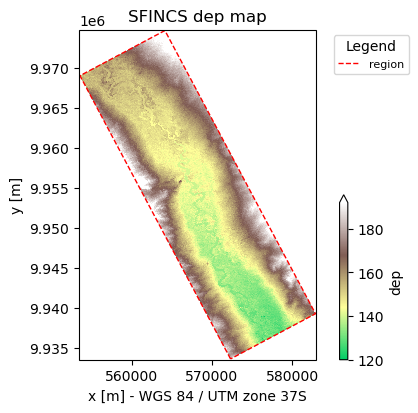

In [5]:
# Also print some statistics
dem = data_catalog.get_rasterdataset("merit_hydro")["elevtn"]

# print(dem)
# nan_count = xr.where(dem.isnull(), 1, 0).sum()
# print("Number of NaN values:", int(nan_count))
# nan_count = xr.where(dem.isnull() | (dem == dem._FillValue), 1, 0).sum()
# print("Number of NaN values including _FillValue:", int(nan_count))
# total_values = dem.size
# print("Total number of values in the DataArray:", total_values)
# print("Fraction:  ", round(float(nan_count/total_values), 1))


datasets_dep = [{"elevtn": "srtm30", "reproj_method": "bilinear"}]
model.setup_dep(datasets_dep=datasets_dep)

print("Plotting")
_ = model.plot_basemap(variable="dep", plot_region=True)

### 4. Make mask of active and inactive cells:


In [6]:
model.setup_mask_active(zmin=120, reset_mask=True)
# _ = model.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

2024-03-12 14:14:43,949 - prepare data catalog - regulargrid - INFO - 0 gaps outside valid elevation range < 10.0 km2.
2024-03-12 14:14:43,953 - prepare data catalog - sfincs - INFO - Derive region geometry based on active cells.


### 5. Update mask with water level and outflow boundary cells - including use of polygons:

Performed after the river generation (5), since the river generation removes intersecting boundaries.

In [7]:
# model.setup_mask_bounds(btype="outflow", zmax=140, reset_bounds=True)

# # # Make a plot of the mask file
# _ = model.plot_basemap(variable="msk", plot_bounds=True)

### 6. Add river inflow/outflow points:

In [8]:
# derive river from hydrography data based on a minimum river length (river_len)
# and minimum upstream area (river_upa)
river_len = 10 # km
river_upa = 400 # km2
river_width = 150 # m

model.setup_river_inflow(
    hydrography="merit_hydro", 
    river_len=river_len, 
    river_upa=river_upa, 
    river_width=river_width, 
    keep_rivers_geom=True
)

2024-03-12 14:14:44,007 - prepare data catalog - rasterdataset - INFO - Reading merit_hydro raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\s05e035\{variable}.tif


2024-03-12 14:14:44,059 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.481, -0.600, 39.745, -0.230] (epsg:4326))
2024-03-12 14:14:48,568 - prepare data catalog - sfincs - INFO - Found 2 river inflow points.


2024-03-12 14:14:48,619 - prepare data catalog - regulargrid - DEBUG - outflow (mask=3) boundary cells reset.


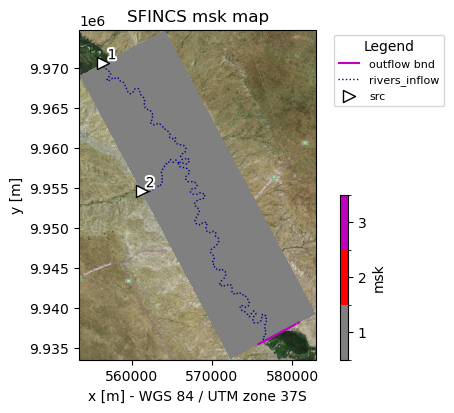

In [9]:
# Outflow boundary
model.setup_mask_bounds(btype="outflow", zmax=140, reset_bounds=True)

# Make a plot of model
# note the src points and derived river network
fig, ax = model.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

In [10]:
# gdf_riv = model.geoms["rivers_inflow"].copy()

# print(gdf_riv)

# gdf_riv["rivbed"]   = "srtm30"
# # gdf_riv["mask"]     = "grwl_mask"
# gdf_riv["manning"]  = 0.03  # manning coefficient [s.m-1/3]
# # gdf_riv[["geometry", "rivwth", "rivdph", "manning"]]

# datasets_riv = [{"centerlines": gdf_riv}]


### 7. Add spatially varying roughness data:

In [11]:
datasets_rgh = [{"lulc": "vito"}]

### 8. Make subgrid derived tables:

2024-03-12 14:14:52,089 - prepare data catalog - rasterdataset - INFO - Reading srtm30 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\srtm30\STRM30DEM_tana.tif
2024-03-12 14:14:52,118 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.481, -0.600, 39.745, -0.230] (epsg:4326))
2024-03-12 14:14:52,130 - prepare data catalog - rasterdataset - INFO - Reading vito raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\landuse\landuse_vito_tana1.tif
2024-03-12 14:14:52,158 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.481, -0.600, 39.745, -0.230] (epsg:4326))
2024-03-12 14:14:52,161 - prepare data catalog - dataframe - INFO - Reading  csv data from c:\Users\pjdeb\anaconda3\envs\hydromt-sfincs\lib\site-packages\hydromt_sfincs\data\lulc\vito_mapping.csv


The nodata value None is not in the reclass table.None will be used for the params.


2024-03-12 14:14:52,195 - prepare data catalog - subgrid - INFO - Number of regular cells in a block : 100
2024-03-12 14:14:52,196 - prepare data catalog - subgrid - INFO - Number of blocks in n direction    : 4
2024-03-12 14:14:52,197 - prepare data catalog - subgrid - INFO - Number of blocks in m direction    : 2
2024-03-12 14:14:52,198 - prepare data catalog - subgrid - INFO - Grid size of flux grid            : dx=99.99999999999969, dy=99.99999999999815
2024-03-12 14:14:52,199 - prepare data catalog - subgrid - INFO - Grid size of subgrid pixels       : dx=4.999999999999984, dy=4.999999999999908
2024-03-12 14:14:52,199 - prepare data catalog - subgrid - INFO - block 1/8 -- col 0:99 | row 0:99
2024-03-12 14:14:53,572 - prepare data catalog - subgrid - DEBUG - Processing subgrid tables for 10000 active cells..
2024-03-12 14:15:06,933 - prepare data catalog - subgrid - INFO - block 2/8 -- col 0:99 | row 100:199
2024-03-12 14:15:08,165 - prepare data catalog - subgrid - DEBUG - Process

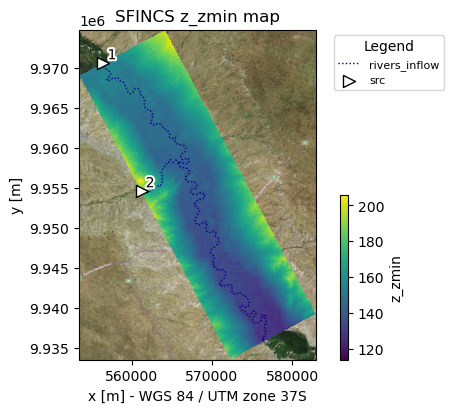

In [12]:
model.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_rgh=datasets_rgh,
    # datasets_riv=datasets_riv,
    nr_subgrid_pixels=20,
    # z_minimum=120,
    write_dep_tif=True,
    write_man_tif=False,
)

# uncomment to see the subgrid table variales
# sf.subgrid

# we can plot the 2D subgrid variables
_ = model.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, bmap="sat", zoomlevel=12
)

### 9. Add spatially varying infiltration data:

In [14]:
# independent from subgrid files
# curve number infiltration based on global CN dataset
model.setup_cn_infiltration("gcn250", antecedent_moisture="avg")

# check all variables in the sf.grid dataset
model.grid.data_vars.keys()

2024-03-12 14:15:38,902 - prepare data catalog - rasterdataset - INFO - Reading gcn250 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\gcn250\{variable}.tif
2024-03-12 14:15:39,010 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.481, -0.600, 39.745, -0.230] (epsg:4326))


KeysView(Data variables:
    dep      (y, x) float64 384kB 187.0 187.0 184.0 188.0 ... 201.0 201.0 197.0
    msk      (y, x) uint8 48kB 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    scs      (y, x) float64 384kB dask.array<chunksize=(400, 120), meta=np.ndarray>)

### 10. Add water level time-series as forcing:

### 11. Add an upstream discharge time-series as forcing:

In [ ]:
model.setup_config(
    **{
        "tref": "20100201 000000",
        "tstart": "20100205 000000",
        "tstop": "20100207 000000",
    }
)

time = pd.date_range(
    start=utils.parse_datetime(model.config["tstart"]),
    end=utils.parse_datetime(model.config["tstop"]),
    periods=3,
)

In [15]:
# We now use the previously created src discharge points (step 6)
# Alternativly you can also create a new geodataframe with points, similar to the water level forcing points

# make up some discharge data
index = model.forcing["dis"].index

dis = np.array([[2.0, 1.0], [5.0, 2.0], [2.0, 1.0]])
dispd = pd.DataFrame(index=time, columns=index, data=dis)

model.setup_discharge_forcing(timeseries=dispd)

model.forcing.keys()

<xarray.DataArray 'index' (index: 2)> Size: 16B
array([1, 2], dtype=int64)
Coordinates:
  * index        (index) int64 16B 1 2
    geometry     (index) object 16B POINT (556472.1798246232 9970530.64332138...
    uparea       (index) float32 8B 3.142e+04 429.0
    spatial_ref  int32 4B 0


NameError: name 'time' is not defined

### 12. Add spatially varying rainfall data:

### 13. Add weirfile:

### 14. Add observation points:


### 14. Add observation lines:


### 15. Show model:

### 16. Save all files